# Tutorial 4. Immediate mode

In this tutorial we will talk about a cute feature about Caffe2: immediate mode.

From the previous tutorials you have seen that Caffe2 *declares* a network, and during this declaration phase, nothing gets actually executed - it's like writing the source of a program, and "compilation/execution" only happens later.

This sometimes gets a bit tricky if we are in a researchy mind, and want to inspect typical intermediate outputs as we go. This is when the immediate mode come to help. At a high level, what the immediate mode does is to run the corresponding operators as you write them. The results live under a special workspace that can then be accessed via `FetchImmediate()` and `FeedImmediate()` runs.

Let's show some examples.

In [1]:
from caffe2.python import cnn, core, visualize, workspace
import numpy as np
import os
core.GlobalInit(['caffe2', '--caffe2_log_level=-1'])

True

Now, as we have known before, in the normal mode, when you create an operator, we are *declaring* it only, and nothing gets actually executed. Let's re-confirm that.

In [2]:
workspace.ResetWorkspace()
# declaration
op = core.CreateOperator("GaussianFill", [], "X", shape=[3, 5])
print('Before execution, workspace contains X: {}'
      .format(workspace.HasBlob("X")))
# execution
workspace.RunOperatorOnce(op)
print('After execution, workspace contains X: {}'
      .format(workspace.HasBlob("X")))

Before execution, workspace contains X: False
After execution, workspace contains X: True


## Entering and exiting immediate mode.

Entering immediate mode is easy: you basically invoke `workspace.StartImmediate()`. Since immediate mode has quite a lot of side effects, it would be good to read through the warning message to make sure you understand the implications.

(If you don't want to see the messages, pass `i_know=True` to `StartImmediate` to suppress that.)

In [3]:
workspace.StartImmediate()


    Enabling immediate mode in caffe2 python is an EXTREMELY EXPERIMENTAL
    feature and may very easily go wrong. This is because Caffe2 uses a
    declarative way of defining operators and models, which is essentially
    not meant to run things in an interactive way. Read the following carefully
    to make sure that you understand the caveats.

    (1) You need to make sure that the sequences of operators you create are
    actually runnable sequentially. For example, if you create an op that takes
    an input X, somewhere earlier you should have already created X.

    (2) Caffe2 immediate uses one single workspace, so if the set of operators
    you run are intended to be under different workspaces, they will not run.
    To create boundaries between such use cases, you can call FinishImmediate()
    and StartImmediate() manually to flush out everything no longer needed.

    (3) Underlying objects held by the immediate mode may interfere with your
    normal run. For example,

Now that you have enabled immediate mode, any operators you run will simultaneously be executed in a separate immediate workspace. Note - the main workspace that you are working on is not affected. We designed the immediate workspace to be separate from the main workspace, so that nothing in the main workspace gets polluted.

In [4]:
# declaration, and since we are in immediate mode, run it in the immediate workspace.
op = core.CreateOperator("GaussianFill", [], "X", shape=[3, 5])
print('Before execution, does workspace contains X? {}'
      .format(workspace.HasBlob("X")))
print('But we can access it using the Immediate related functions.'
      'Here is a list of immediate blobs:')
print(workspace.ImmediateBlobs())
print('The content is like this:')
print(workspace.FetchImmediate('X'))

Before execution, does workspace contains X? True
But we can access it using the Immediate related functions.Here is a list of immediate blobs:
['X']
The content is like this:
[[ 0.87197119  0.02245325 -0.48256612 -0.70905411  0.1288138 ]
 [-0.81278008 -0.25046423 -0.58188307  0.48693365 -0.35712072]
 [-0.03426806 -0.92325109 -0.00854768 -0.8590107   0.24451831]]


In [5]:
# After the immediate execution, you can invoke StopImmediate() to clean up.
workspace.StopImmediate()

## Manually feeding blobs

But wait, you say - what if I want to create an operator that uses an input that is "declared" but not present yet? Since the immediate workspace does not have the input, we will encounter an exception:

In [6]:
workspace.StartImmediate(i_know=True)
op = core.CreateOperator("Relu", "X", "Y")

RuntimeError: [enforce fail at operator.cc:25] blob != nullptr. Encountered a non-existing input blob: X

This is because immediate mode, being completely imperative, requires any input to be used to already exist in the immediate workspace. To make the immediate mode aware of such external inputs, we can manually feed blobs to the immediate workspace.

In [7]:
X = np.random.randn(2, 3).astype(np.float32)
workspace.FeedImmediate("X", X)
# Now, we can safely run CreateOperator since immediate mode knows what X looks like
op = core.CreateOperator("Relu", "X", "Y")
print("Example input is:\n{}".format(workspace.FetchImmediate("X")))
print("Example output is:\n{}".format(workspace.FetchImmediate("Y")))

Example input is:
[[-0.44337013 -0.31392127 -0.85655093]
 [ 0.24599633  0.69237536 -0.30405223]]
Example output is:
[[ 0.          0.          0.        ]
 [ 0.24599633  0.69237536  0.        ]]


In [8]:
workspace.StopImmediate()

## When is immediate mode useful?

You might want to use immediate mode when you are not very sure about the shape of the intermediate results, such as in a CNN where there are multiple convolution and pooling layers. Let's say that you are creating an MNIST convnet model but don't want to calculate the number of dimensions for the final FC layer. Here is what you might want to do.

Feature dimensions before FC layer: (50, 4, 4)
Blob data has shape: (64, 1, 28, 28)
Blob conv1 has shape: (64, 20, 24, 24)
Blob pool1 has shape: (64, 20, 12, 12)
Blob conv2 has shape: (64, 50, 8, 8)
Blob pool2 has shape: (64, 50, 4, 4)
Blob fc3 has shape: (64, 500)
Blob pred has shape: (64, 10)
Sample input:


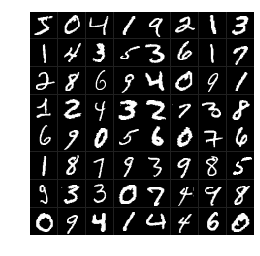

In [9]:
model = cnn.CNNModelHelper(order="NCHW", name="mnist")
# Start the immediate mode.
workspace.StartImmediate(i_know=True)

data_folder = os.path.join(os.path.expanduser('~'), 'python', 'tutorial_data')
data_uint8, label = model.TensorProtosDBInput(
    [], ["data_uint8", "label"], batch_size=64,
    db=os.path.join(data_folder, 'mnist/mnist-train-nchw-minidb'),
    db_type='minidb')
data = model.Cast(data_uint8, "data", to=core.DataType.FLOAT)
data = model.Scale(data, data, scale=float(1./256))
data = model.StopGradient(data, data)
conv1 = model.Conv(data, 'conv1', 1, 20, 5)
pool1 = model.MaxPool(conv1, 'pool1', kernel=2, stride=2)
conv2 = model.Conv(pool1, 'conv2', 20, 50, 5)
pool2 = model.MaxPool(conv2, 'pool2', kernel=2, stride=2)

# What is the shape of pool2 again...?
feature_dimensions = workspace.FetchImmediate("pool2").shape[1:]
print("Feature dimensions before FC layer: {}".format(feature_dimensions))

fc3 = model.FC(pool2, 'fc3', int(np.prod(feature_dimensions)), 500)
fc3 = model.Relu(fc3, fc3)
pred = model.FC(fc3, 'pred', 500, 10)
softmax = model.Softmax(pred, 'softmax')

# Let's see if the dimensions are all correct:
for blob in ["data", "conv1", "pool1", "conv2", "pool2", "fc3", "pred"]:
    print("Blob {} has shape: {}".format(
          blob, workspace.FetchImmediate(blob).shape))
# Let's also visualize a sample input.
print("Sample input:")
visualize.NCHW.ShowMultiple(workspace.FetchImmediate("data"))
workspace.StopImmediate()

Remember, immediate mode is only intended to be used in debugging mode, and are only intended for you to verify things interactively. For example, in the use case above, what you want to do eventually is to remove the feature_dimensions argument and replace it with code that do not depend on immediate mode, such as hard-coding it.

## Departing words

Immediate mode could be a useful tool for quick iterations. But it could also easily go wrong. Make sure that you understand its purpose, and never abuse it in real product environments. The philosophy of Caffe2 is to make things very flexible and this is one example of it, but it also makes you easy to shoot yourself in the foot. Take care :)